In a new python environment with python>=3.10

In [1]:
!pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev"

  Cloning https://github.com/ENSTA-U2IS-AI/torch-uncertainty (to revision dev) to /tmp/pip-install-1002_58p/torch-uncertainty_7f6f6811dd6c4e79b5707e355f8ee931
  Running command git clone --filter=blob:none --quiet https://github.com/ENSTA-U2IS-AI/torch-uncertainty /tmp/pip-install-1002_58p/torch-uncertainty_7f6f6811dd6c4e79b5707e355f8ee931
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  branch 'dev' set up to track 'origin/dev'.
  Resolved https://github.com/ENSTA-U2IS-AI/torch-uncertainty to commit efb7cd9d26b22a8f67d3fd889d5ff42c70e6f4a9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# here are the training parameters
batch_size = 16
learning_rate = 2e-2
weight_decay=5e-4
lr_decay_epochs=40
lr_decay=0.1
nb_epochs=100
# Skip training and load model locally.
# If never trained, set to False to train and save the model first.
skip_training = True # True to skip

In [3]:
import torch
import numpy as np
import json
from einops import rearrange
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F

from torch_uncertainty.datasets import MUAD


import os
#My personal token
os.environ["HF_TOKEN"] = "HF_TOKEN_PLACEHOLDER"

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_set = MUAD(root="./data", target_type="semantic", version="small", split="train" , transforms=train_transform, download=True)
val_set = MUAD(root="./data", target_type="semantic", version="small", split="val" , transforms=val_transform, download=True)
test_set = MUAD(root="./data", target_type="semantic", version="small", split="test" , transforms=val_transform, download=True)

/users/eleves-b/2024/huanshan.huang/miniconda3/envs/inf554/lib/python3.12/site-packages/torchmetrics/__init__.py:31: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  import scipy.signal


Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [4]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

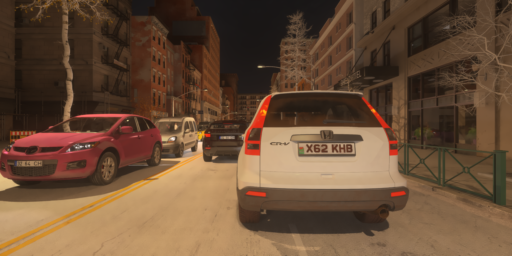

In [5]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

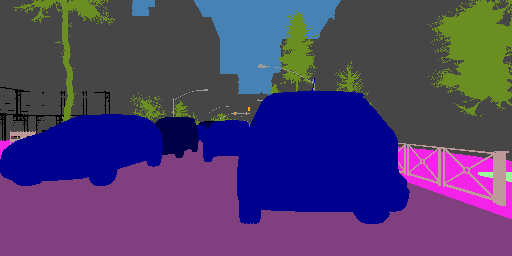

In [6]:
from torchvision.utils import draw_segmentation_masks

tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [7]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name}, Train ID: {train_id}, Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

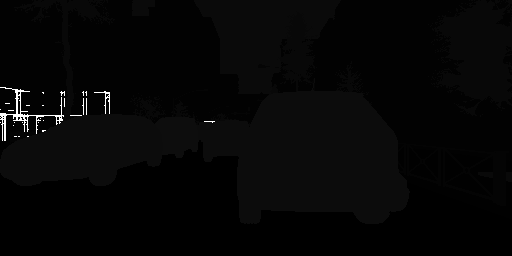

In [8]:
im = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
im

In [9]:
im.size
print(np.array(im))

[[2 2 2 ... 8 8 8]
 [2 2 2 ... 8 8 8]
 [2 2 2 ... 8 8 8]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Why is the target image dark and what's the bright part ?** **(hint : print the numpy array)**

A: The most part of the image is dark because the value of each pixel (elements in the printed array, e.g., 2, 8, 0, and so on) represents the class ID as the table shown before. Since the pixel range is $[0,255]$ where 0 represents black and 255 represents white, we see most part of the image is black with the fact that most items are recognized by the model, while some of them are not and labeled with class ID 255, being white in the image.

**Q3/ please study the dataset a bit. What it is about?**

A3: MUAD is a uncertainty benchmark dataset for various tasks in autonomous driving. According to the configuration, we are now using the small version of MUAD, with a target of semantics (instead of depth). The corresponding ground truth information each sample in the dataset includes mainly semantic segmentation and the depth map, and the configuration shows our goal of semantic segmentation.

In [10]:
import numpy as np
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)

test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)


In [11]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): AN additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    for _, label in dataloader:
      label = label.cpu().numpy()
      # Flatten label
      flat_label = label.flatten()
      flat_label = flat_label[flat_label != 255]

      # Sum up the number of pixels of each class and the total pixel
      # counts for each label
      class_count += np.bincount(flat_label, minlength=num_classes)
      total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [12]:
print("\nComputing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().cuda()
print("Class weights:", class_weights)


Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444,  5.2256, 21.1894, 50.4983, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


**Q4/ why do we need to evaluate the class_weights?**

A4: The sample number of each class is different (i.e., the dataset itself is not balanced). This means potential big differences among the weights of classes, which leads to the case that the model is biased to the majority classes with many samples in the dataset and ignore the minority. We introduce a custom class weighing scheme from ENet to restrict the weights in a certain range, so as for weighting the loss function during training to signal to the model that it should pay more attention to samples from minority classes.

## C. building the DNN

**Q5/ Do we really use Unet? What did I change :)? (that is hard)**

A5: Yes, but a little bit different from the original Unet. There are no dropout layers in the decoder part of the original one. You insert dropout layers for uncertainty evaluation.



**Q6/Do we need a backbone with Unet?**

A6: No, we don't, at least not necessary. The Unet is a complete encoder-decoder architecture which can complete the end-to-end problem, i.e., takes as input the images and outputs the segmentation map. Though we can load pretrained networks like resnets as the backbone, or encoder, to enhance the performance, that is not necessary.




In [13]:
from torch import nn


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(x1, size=[2*x1.size()[2],2*x1.size()[3]],
                          interpolation=v2.InterpolationMode.BILINEAR)
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

#please note that we have added dropout layer to be abble to use MC dropout

class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [14]:
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/  what is the IoU?**

A7: IoU, Intersection over Union, is defined as:
$$

IoU = \frac{\text{area of overlap}}{\text{area of union}}

$$
This is a metric to evaluate the accuracy of the model, which preliminarily satisfies the requirement for calculating the geometric similarity between two images, providing a straightforward implementation of image overlap measurement. However, it fails to account for the distance between the two shapes or the similarity in their aspect ratios.


### Training function

**Q8/Please complete the training and the test function**

In [15]:
from torchmetrics.utilities.compute import _safe_divide


def train( model, data_loader, optim, criterion, metric,iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        labels[labels >= 19] = 255
        # Squeeze the channel dimension if present: [B, 1, H, W] -> [B, H, W]
        if labels.ndim == 4 and labels.shape[1] == 1:
            labels = labels.squeeze(1)
        # Forward propagation
        outputs = model(img)
        
        # Loss computation
        loss = criterion(outputs, labels)

        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()


        # Flatten the outputs and labels for metric computation
        flatten_logits = rearrange(outputs, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255
        
        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

### Validation function

In [16]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        labels[labels >= 19] = 255
        # Squeeze the channel dimension if present: [B, 1, H, W] -> [B, H, W]
        if labels.ndim == 4 and labels.shape[1] == 1:
            labels = labels.squeeze(1)
        with torch.no_grad():
            # Forward propagation
            outputs = model(img)
            
            # Flatten the outputs and labels for metric computation
            flatten_logits = rearrange(outputs, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255

            # Loss computation
            loss = criterion(outputs, labels)

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_logits[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

## E. Training Process

**Q9/ please train your DNN and comment?**



In [17]:
from torch import optim
from torch.optim import lr_scheduler

from torch_uncertainty.metrics.segmentation import MeanIntersectionOverUnion

print("\nTraining...\n")
num_classes = 19
# Intialize UNet
model = UNet(num_classes)
model = model.cuda()
print(f"\nRe-computing class weights for {num_classes} classes...")
full_weights = enet_weighing(train_loader, 21) 
class_weights = torch.from_numpy(full_weights[:num_classes]).float().cuda()
# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion  combines LogSoftMax and NLLLoss.
criterion = torch.nn.CrossEntropyLoss(weight=class_weights,ignore_index=255)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nb_epochs)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay)


print("Class weights shape:", class_weights.shape)
print("Class weights:", class_weights)


Training...


Re-computing class weights for 19 classes...
Class weights shape: torch.Size([19])
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444,  5.2256, 21.1894, 50.4983, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


Using device: cuda
Loaded training history from file.


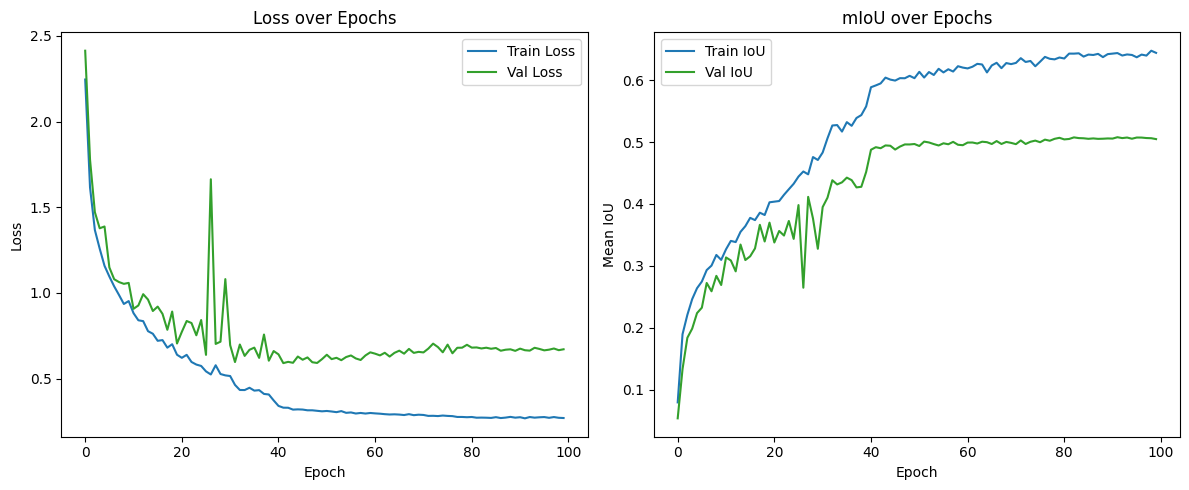

In [18]:
# Start Training
# Training loop
train_losses = []
train_IoU = []
val_losses = []
val_IoU = []

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
metric_train_obj = MeanIntersectionOverUnion(num_classes=num_classes).to(device)
metric_val_obj = MeanIntersectionOverUnion(num_classes=num_classes).to(device)

if skip_training:
    if os.path.exists("training_history.json"):
        with open("training_history.json", "r") as f:
            history_data = json.load(f)
            train_losses = history_data["train_losses"]
            train_IoU = history_data["train_IoU"]
            val_losses = history_data["val_losses"]
            val_IoU = history_data["val_IoU"]
        print("Loaded training history from file.")
    else:
        print("No history file found. Train the model first.")

else:
    print("Start training...")
    # Initialize metric objects globally for the loop (optional, but cleaner if reset inside)

    for epoch in range(nb_epochs):
        # Train and Validate
        # Note: train/val functions return (loss, per_class_iou, mean_iou) based on your implementation
        train_loss, IoU_per_class_train, _ = train(model, train_loader, optimizer, criterion, metric_train_obj)
        val_loss, IoU_per_class_val, _ = test(model, val_loader, criterion, metric_val_obj)
        
        # Scheduler step
        scheduler.step()
        
        # Record history
        train_losses.append(train_loss)
        # Calculate mean of per-class IoU manually or use the 3rd return value from your function
        train_IoU.append(IoU_per_class_train.nanmean().item()) 
        
        val_losses.append(val_loss)
        val_miou = IoU_per_class_val.nanmean().item()
        val_IoU.append(val_miou)
        
        print(f"Epoch {epoch+1}/{nb_epochs} | Train Loss: {train_loss:.4f} | Train mIoU: {train_IoU[-1]:.4f} | Val Loss: {val_loss:.4f} | Val mIoU: {val_miou:.4f}")

        # # Save best model logic
        # if val_miou > best_iou:
        #     best_iou = val_miou
        #     torch.save(model.state_dict(), 'unet_best.pth')
        #     print("  -> Best model saved!")

    # Save final model as well
    torch.save(model.state_dict(), 'unet.pth')


    history_data = {
        "train_losses": train_losses,
        "train_IoU": train_IoU,
        "val_losses": val_losses,
        "val_IoU": val_IoU
    }

    with open("training_history.json", "w") as f:
        json.dump(history_data, f)
        print("Training history saved to training_history.json")


# Plotting ONCE at the end
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color=colors[0])
plt.plot(val_losses, label='Val Loss', color=colors[1])
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_IoU, label='Train IoU', color=colors[0])
plt.plot(val_IoU, label='Val IoU', color=colors[1])
plt.title('mIoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves_unet.png", dpi=200, bbox_inches="tight")
plt.show()



Load a model

In [19]:
#Loading a model
model = UNet(19)
model.load_state_dict(torch.load("unet.pth"))
model = model.to("cuda")

# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ please plot the loss and miou and comment about it ?**
Both the training and test loss curves show a similar downward trend, stabilizing around 0.3. However, there's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.75, whereas the test mIoU plateaus at around 0.65. This discrepancy indicates a definite overfitting to the training dataset.

A10: The curve is similar to the description, we note that the model is potentially overfitting.

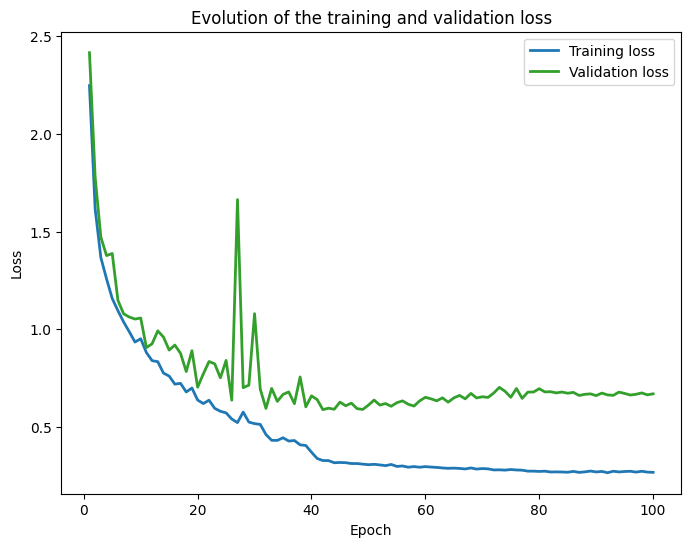

In [20]:
plot_losses(train_losses, val_losses)

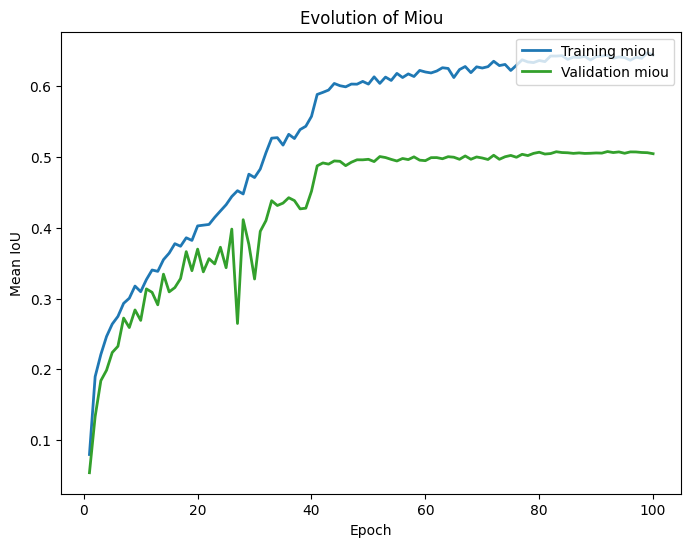

In [21]:
plot_accu(train_IoU, val_IoU)

**Q11/ what should we have done to avoid overfitting?**

A11: We have introduced dropout layers in the decoder part of Unet. To further avoid overfitting, we can:

1. Increase the dropout values (e.g., 0.2 to 0.3)
2. Augment the dataset with random erasing, cropping, erasing, and so on, in order to force the model to learn local features of an image.
3. Use an optimizer with weight decay.

In [22]:
# Now we evaluate the model on all the test set.
metric_test_obj = MeanIntersectionOverUnion(num_classes=num_classes).to(device)
loss, iou, miou = test(model, test_loader, criterion, metric_test_obj)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss ," | Mean IoU: ", miou)
class_names = [c.name for c in test_set.classes if c.id < 19]
# Print per class IoU on last epoch or if best iou
for key, class_iou in zip(class_names, iou, strict=True):
  print(f"{key}: {class_iou:.4f}")

>>>> [FINAL TEST on the test set: ] Avg. loss:  0.6687537602015904  | Mean IoU:  tensor(0.5525, device='cuda:0')
road: 0.9550
sidewalk: 0.7848
building: 0.8159
wall: 0.6941
fence: 0.5029
pole: 0.3285
traffic_light: 0.2495
traffic_sign: 0.0940
vegetation: 0.6036
terrain: 0.0499
sky: 0.9239
person: 0.5559
car: 0.8001
truck: 0.3773
bus: nan
rider: nan
train: nan
motorcycle: nan
bicycle: nan


## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


In [23]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

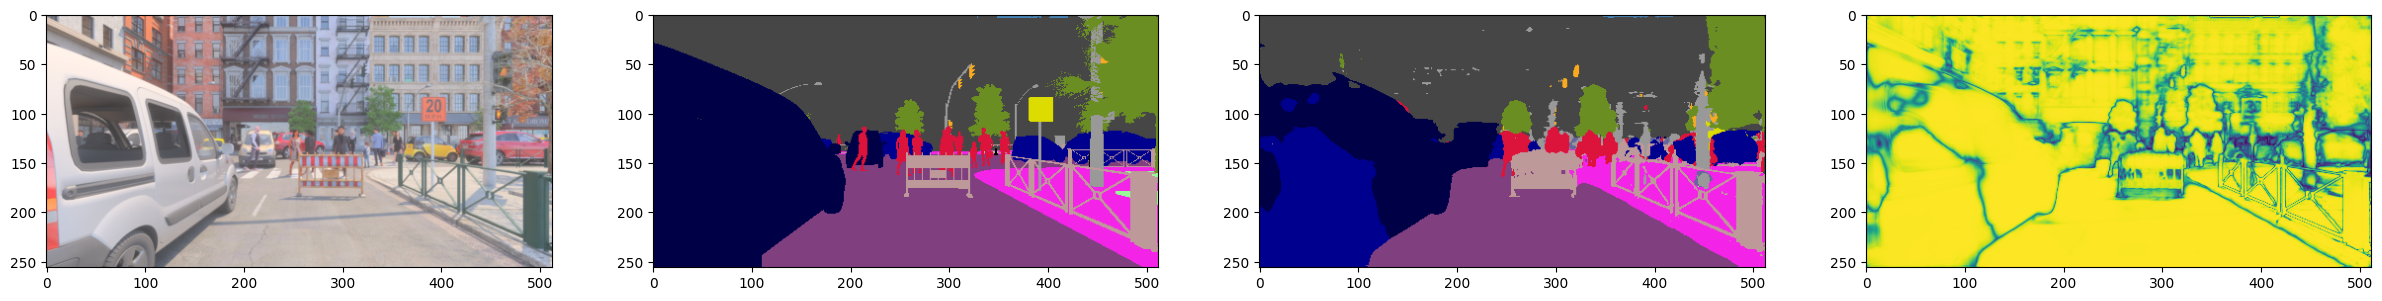

In [24]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**

Because the image visualizes the maximum class probability, a proxy for the model's confidence. Bright and yellow areas represent high confidence, meaning that the model is confident that its prediction in these areas. The dark areas represent low confidence, and the model represents uncertainty here.

### Now let's load the OOD test set

In [25]:
test_ood_set = MUAD(root="./data", target_type="semantic", version="small", split="ood" , transforms=val_transform, download=True)
test_ood_set

Dataset MUAD
    Number of datapoints: 20
    Root location: data/MUAD_small
    Compose(
      Resize(size=[256, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [26]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

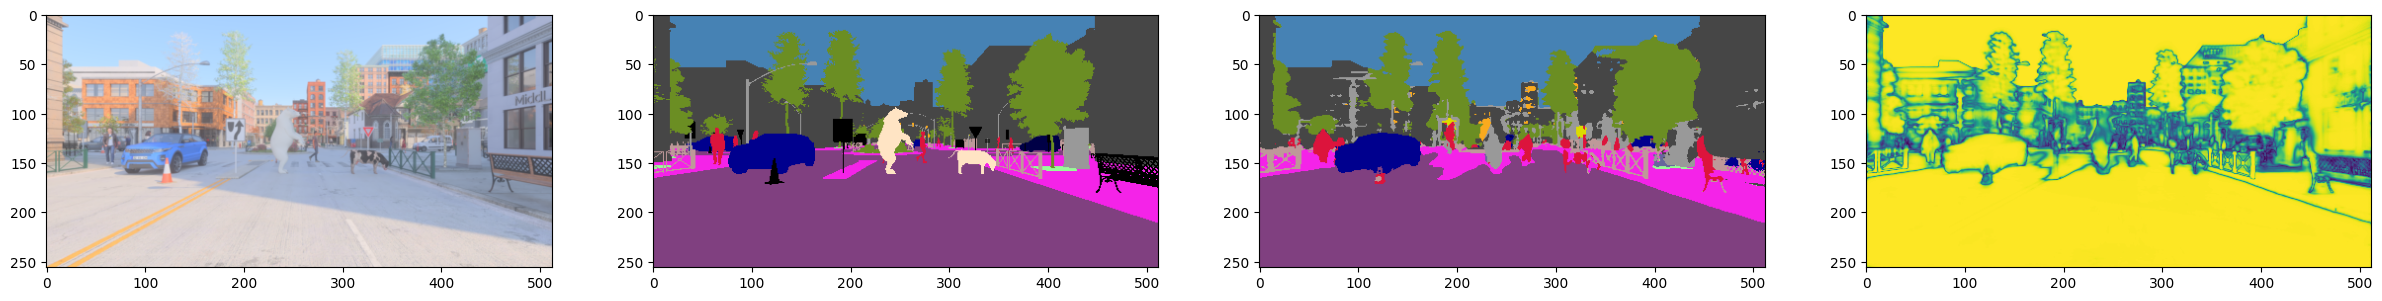

In [27]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**According to the output is the model confident when it comes to labeling the bear and goat ? How about the bench ?**

A: The model is over-confident when it comes to labeling the bear, the goat, and the bench. We train the model under the case that we ignore classes with ID greater than 19, such that those classes can be used as OOD objects. In the last image, the areas corresponding to the bear and the goat, and the bench are darker than the surrounding yellow marked items that the model is confident about, but not dark enough. They are still quite bright, i.e., the model is over-confident about these OOD objects, though the model doesn't know what they are. This means the model incorrectly classifies them as something In-Distribution. In specific, the bear in the 3rd image is marked in blue, which means it is classified as a car, and similarly the goat is classified as a pedestrian, the bench is divided into several parts corresponding to sidewalk, fence, and pedestrian.


**Q12 bis/ The last image is the related to the confidence score of the DNN. Can you explain why?**
**Are you happy with this image?**

Because the image visualizes the maximum class probability, a proxy for the model's confidence. As we mentioned before, bright and yellow areas represent high confidence, meaning that the model is confident that its prediction in these areas. The dark areas represent low confidence, and the model represents uncertainty here.

We are not happy with this image, because the model is over-confident and tends to classify OOD objects as ID objects. Ideally, for those OOD objects, corresponding areas in the confidence map should be dark or blue, however, the fact that it is bright yellow indicates that the model is poorly calibrated and fails to flag these anomalies as unknown.

## C. Uncertainty evaluations with Temperature Scaling
**Q13/ please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

ECE before temperature scaling: 4.41%


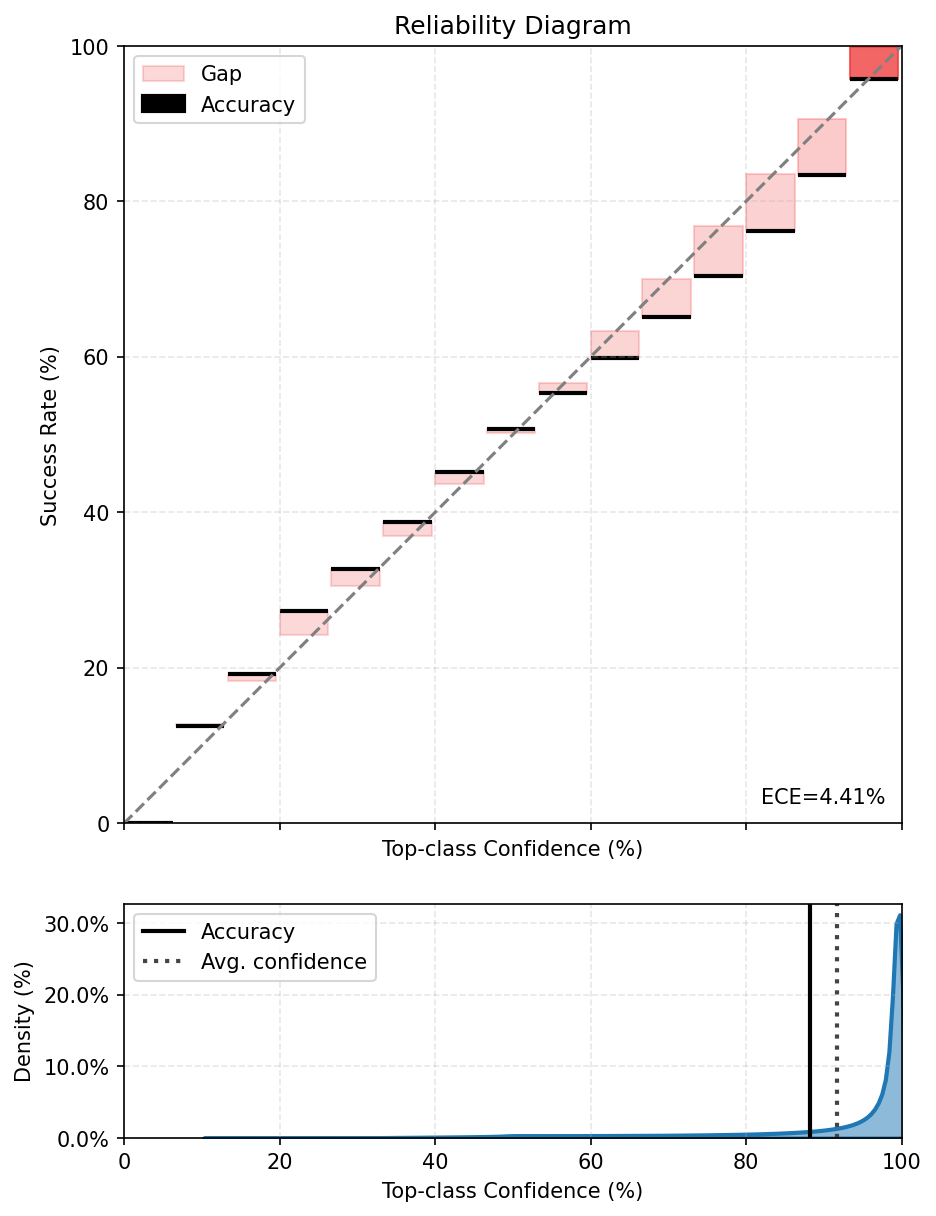

In [28]:
from torch_uncertainty.metrics import CalibrationError

# Compute ECE on the test set
ece_metric = CalibrationError(task='multiclass',num_classes=num_classes, num_bins=15, norm="l1").to(device)
model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        img = batch_data[0].to(device)
        labels = batch_data[1].to(device)
        labels[labels >= 19] = 255
        if labels.ndim == 4 and labels.shape[1] == 1:
            labels = labels.squeeze(1)
        
        outputs = model(img) # Logits
        outputs_proba = outputs.softmax(dim=1) # Probabilities
        flatten_probs = rearrange(outputs_proba, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        
        valid_mask = flatten_labels != 255
        ece_metric.update(flatten_probs[valid_mask], flatten_labels[valid_mask])

print(f"ECE before temperature scaling: {ece_metric.compute()*100.0:.2f}%")
fig, ax = ece_metric.plot()
plt.show()

**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**

A: The model is overconfident. In the first plot, when the confidence is greater than 60%, the red gap is below the diagnal, meaning that the average confidence is higher than true accuracy. What's more, in the second plot, we see that the majority of the predictions cluster at high confidence region, and the average confidence is on the right of accuracy, indicating that the model is overconfident.


After temperature scaling

In [29]:
from torch_uncertainty.post_processing import TemperatureScaler



Now let's see the new confidence score image after scaling

Optimizing Temperature on Validation Set...


/users/eleves-b/2024/huanshan.huang/miniconda3/envs/inf554/lib/python3.12/site-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


Optimal Temperature found: 1.3396

Evaluating on Test Set with Temperature Scaling...
ECE After temperature scaling: 3.59%


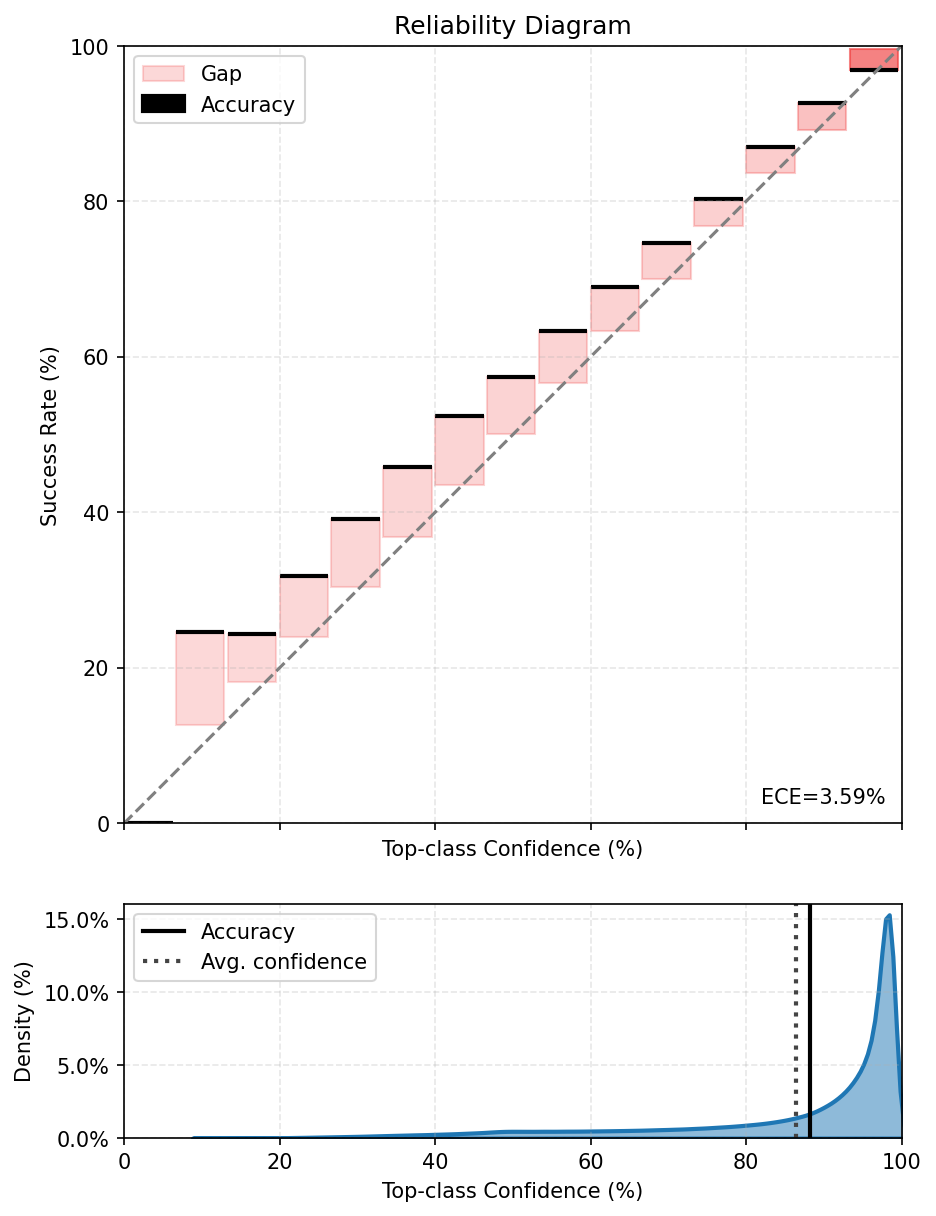

In [30]:
from torch_uncertainty.metrics import CalibrationError
from einops import rearrange

print("Optimizing Temperature on Validation Set...")
model.eval()
val_logits_list = []
val_targets_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        if labels.ndim == 4: labels = labels.squeeze(1)
        
        logits = model(images)
        
        logits = rearrange(logits, "b c h w -> (b h w) c")
        labels = labels.flatten()
        valid_mask = labels != 255
        
        val_logits_list.append(logits[valid_mask])
        val_targets_list.append(labels[valid_mask])

val_logits_concat = torch.cat(val_logits_list)
val_targets_concat = torch.cat(val_targets_list)
temperature = nn.Parameter(torch.ones(1).cuda() * 1.5)
nll_criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=50)

def eval_nll():
    optimizer.zero_grad()
    loss = nll_criterion(val_logits_concat / temperature, val_targets_concat)
    loss.backward()
    return loss

optimizer.step(eval_nll)
final_temp = temperature.item()
print(f"Optimal Temperature found: {final_temp:.4f}")
print("\nEvaluating on Test Set with Temperature Scaling...")
ece_metric_scaled = CalibrationError(task='multiclass', num_classes=num_classes, num_bins=15, norm="l1").to(device)

class ScaledModel(nn.Module):
    def __init__(self, model, temp):
        super().__init__()
        self.model = model
        self.temp = temp
    def forward(self, x):
        return self.model(x) / self.temp

scaled_model = ScaledModel(model, final_temp)
scaled_model.eval()

with torch.no_grad():
    for batch_data in test_loader:
        img = batch_data[0].to(device)
        labels = batch_data[1].to(device)
        labels[labels >= 19] = 255
        if labels.ndim == 4 and labels.shape[1] == 1:
            labels = labels.squeeze(1)

        outputs = scaled_model(img)
        outputs_proba = outputs.softmax(dim=1) 
        flatten_probs = rearrange(outputs_proba, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255
        
        ece_metric_scaled.update(flatten_probs[valid_mask], flatten_labels[valid_mask])

print(f"ECE After temperature scaling: {ece_metric_scaled.compute()*100.0:.2f}%")
fig, ax = ece_metric_scaled.plot()
plt.show()

**Did the model get more confident ? or is it more calibrated ? Commnet on the temperature scaling graphs and results**

A: The model get less confident and more calibrated. A decrease in the ECE value indicates that the predicted probabilities align more closely with actual accuracy, resulting in a reduction of the red gap in the reliability diagram. The avg confidence line in the previous graph before scaling is greater than the one after scaling.

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q\14 Please implement MC Dropout using torch_uncertainty**

Running MC Dropout with T=3...
Running MC Dropout with T=20...
torch.Size([256, 512]) torch.Size([256, 512])


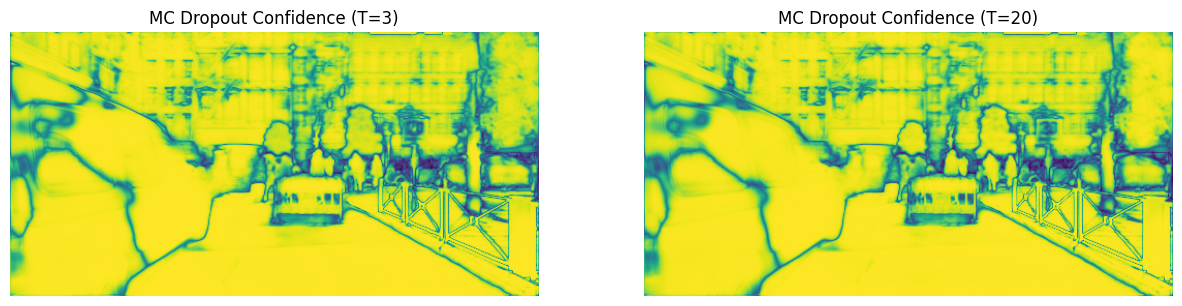


Visualizing MC Dropout (T=3) on ID data...


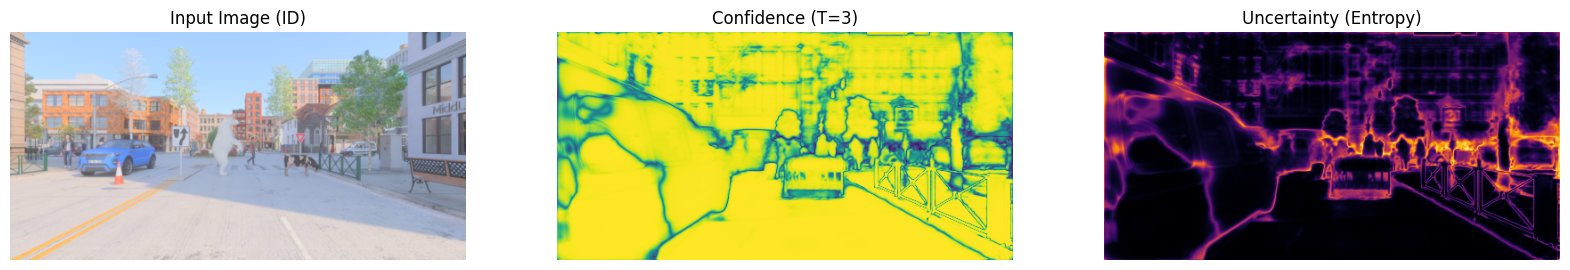


Visualizing MC Dropout (T=3) on OOD data...



Visualizing MC Dropout (T=20) on ID data...



Visualizing MC Dropout (T=20) on OOD data...


MC Dropout (T=3) ECE: 3.19%
MC Dropout (T=20) ECE: 2.87%


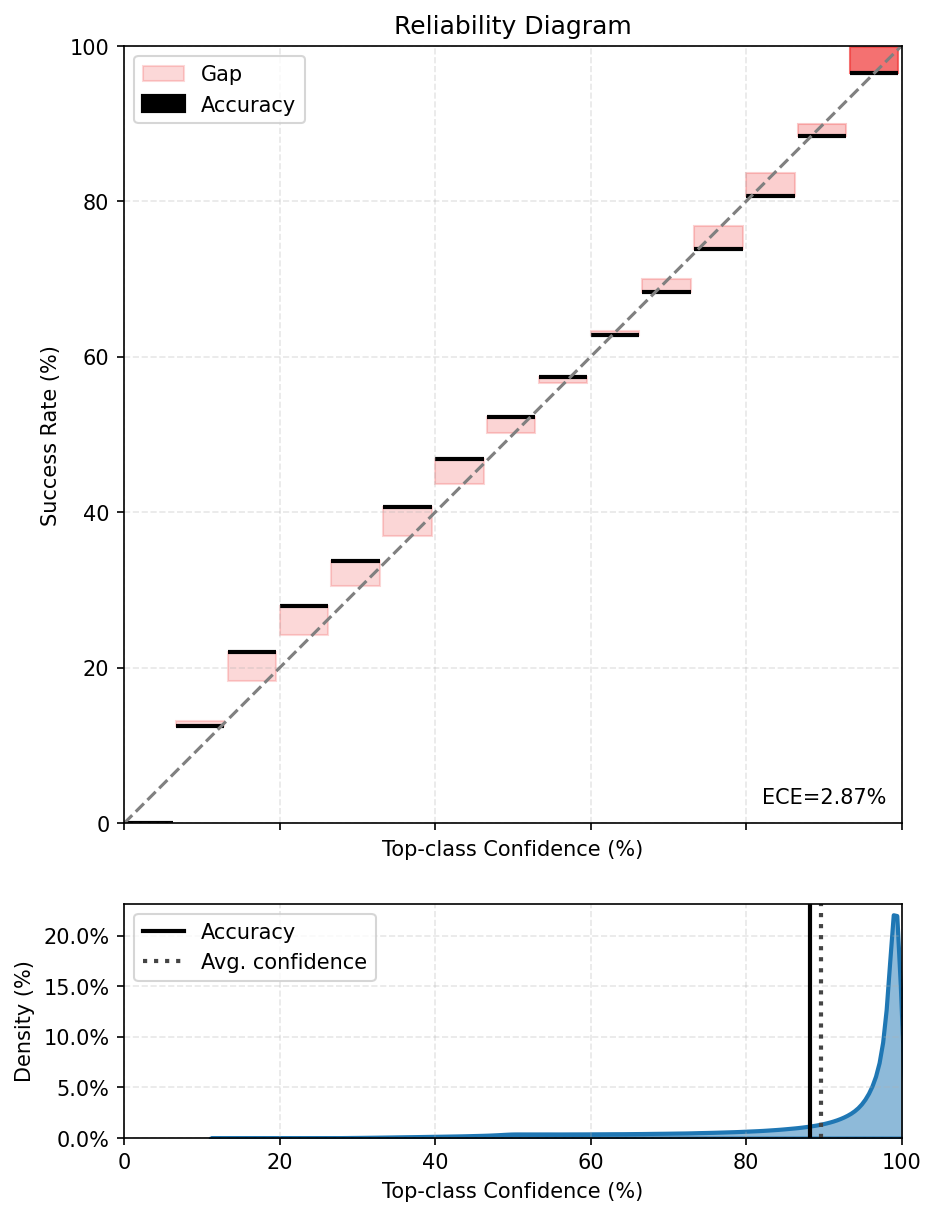

In [31]:
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout

# Config
num_estimators_small = 3
num_estimators_large = 20
def visualize_mc_dropout(model, input_img, num_estimators):
    # Wrap the model with MC Dropout
    # num_estimators corresponds to the number of forward passes (T)
    mc_model = mc_dropout(model, num_estimators=num_estimators)
    mc_model.eval()
    
    with torch.no_grad():
        logits = mc_model(input_img)

        # probs: [B, C, H, W]
        if logits.dim() == 5:
            if logits.shape[0] == num_estimators:          # [M,B,C,H,W]
                probs = logits.softmax(dim=2).mean(dim=0)  # [B,C,H,W]
            elif logits.shape[1] == num_estimators:        # [B,M,C,H,W]
                probs = logits.softmax(dim=2).mean(dim=1)  # [B,C,H,W]
            else:
                raise RuntimeError(f"Unexpected MC logits shape: {tuple(logits.shape)}")

        elif logits.dim() == 4:
            # [M,C,H,W]
            if logits.shape[0] == num_estimators and input_img.shape[0] == 1:
                probs = logits.softmax(dim=1).mean(dim=0, keepdim=True)  # [1,C,H,W]
            else:
                probs = logits.softmax(dim=1)  # [B,C,H,W]
        else:
            raise RuntimeError(f"Unexpected MC logits dims: {logits.dim()}")

        confidence, _ = probs.max(dim=1)      # [B,H,W]
        confidence = confidence.squeeze(0).cpu()  # [H,W]

    return confidence

# Prepare the image
sample_idx = 0
img_raw, _ = test_set[sample_idx]
batch_img = img_raw.unsqueeze(0).cuda()

# MC Dropout with T= num_estimators_small
print(f"Running MC Dropout with T={num_estimators_small}...")
conf_m = visualize_mc_dropout(model, batch_img, num_estimators=num_estimators_small)

# MC Dropout with T= num_estimators_large
print(f"Running MC Dropout with T={num_estimators_large}...")
conf_l = visualize_mc_dropout(model, batch_img, num_estimators=num_estimators_large)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
print(conf_m.shape, conf_l.shape)
ax1.imshow(F.to_pil_image(conf_m))
ax1.set_title(f"MC Dropout Confidence (T={num_estimators_small})")
ax1.axis('off')

ax2.imshow(F.to_pil_image(conf_l))
ax2.set_title(f"MC Dropout Confidence (T={num_estimators_large})")
ax2.axis('off')

plt.show()

print(f"\nVisualizing MC Dropout (T={num_estimators_small}) on ID data...")
sample_idx = 0
img_raw,  _ = test_set[sample_idx]
batch_img = img_raw.unsqueeze(0).cuda() # [1, 3, H, W]

mc_model_small = mc_dropout(model, num_estimators=num_estimators_small)
mc_model_small.eval()

with torch.no_grad():
    logits = mc_model_small(batch_img) 
    
    # Handle shape variations
    if logits.dim() == 4: # [M, C, H, W]
        probs = logits.softmax(dim=1) 
        mean_probs = probs.mean(dim=0) 
    elif logits.dim() == 5: # [M, B, C, H, W]
        probs = logits.softmax(dim=2)
        mean_probs = probs.mean(dim=0).squeeze(0)
    
    confidence_small, _ = mean_probs.max(dim=0)
    entropy_small = -torch.sum(mean_probs * torch.log(mean_probs + 1e-6), dim=0)

confidence_img_small = F.to_pil_image(confidence_small.cpu())

entropy_vis_small = entropy_small.cpu()
entropy_vis_small = (entropy_vis_small - entropy_vis_small.min()) / (entropy_vis_small.max() - entropy_vis_small.min())
entropy_vis_img_small = F.to_pil_image(entropy_vis_small)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(img_pil) # Re-using img_pil from previous block
ax1.set_title("Input Image (ID)")
ax1.axis('off')

ax2.imshow(confidence_img_small)
ax2.set_title(f"Confidence (T={num_estimators_small})")
ax2.axis('off')

ax3.imshow(entropy_vis_img_small, cmap='inferno')
ax3.set_title("Uncertainty (Entropy)")
ax3.axis('off')
plt.show()

print(f"\nVisualizing MC Dropout (T={num_estimators_small}) on OOD data...")
sample_idx = 0
img_ood, _ = test_ood_set[sample_idx]
batch_img_ood = img_ood.unsqueeze(0).cuda()

with torch.no_grad():
    logits = mc_model_small(batch_img_ood)
    
    if logits.dim() == 4:
        probs = logits.softmax(dim=1)
        mean_probs = probs.mean(dim=0)
    elif logits.dim() == 5:
        probs = logits.softmax(dim=2)
        mean_probs = probs.mean(dim=0).squeeze(0)
        
    confidence_ood_small, _ = mean_probs.max(dim=0)
    entropy_ood_small = -torch.sum(mean_probs * torch.log(mean_probs + 1e-6), dim=0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_ood.device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_ood.device)
img_show_ood = img_ood.cpu() * std + mean
img_show_ood = torch.clamp(img_show_ood, 0, 1)
img_pil_ood = F.to_pil_image(img_show_ood.cpu())
entropy_vis_ood_small = entropy_ood_small.cpu()
entropy_vis_ood_small = (entropy_vis_ood_small - entropy_vis_ood_small.min()) / (entropy_vis_ood_small.max() - entropy_vis_ood_small.min())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(img_pil_ood) # Re-using image from previous block
ax1.set_title("Input Image (OOD)")
ax1.axis('off')

ax2.imshow(F.to_pil_image(confidence_ood_small.cpu()))
ax2.set_title(f"Confidence (T={num_estimators_small})")
ax2.axis('off')

ax3.imshow(F.to_pil_image(entropy_vis_ood_small), cmap='inferno')
ax3.set_title("Uncertainty (Entropy)")
ax3.axis('off')
plt.show()

# Visualization on ID
print(f"\nVisualizing MC Dropout (T={num_estimators_large}) on ID data...")
sample_idx = 0
img_raw,  _ = test_set[sample_idx]
batch_img = img_raw.unsqueeze(0).cuda() # [1, 3, H, W]


mc_model_large = mc_dropout(model, num_estimators=num_estimators_large)
mc_model_large.eval()


with torch.no_grad():
    logits = mc_model_large(batch_img) # [M, C, H, W] or [M, B, C, H, W] depending on impl
    
    # Handle shape variations
    if logits.dim() == 4: # [M, C, H, W]
        probs = logits.softmax(dim=1) # [M, C, H, W]
        mean_probs = probs.mean(dim=0) # [C, H, W]
    elif logits.dim() == 5: # [M, B, C, H, W]
        probs = logits.softmax(dim=2)
        mean_probs = probs.mean(dim=0).squeeze(0) # [C, H, W]
    
    confidence, pred = mean_probs.max(dim=0) # [H, W]
    entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-6), dim=0) # [H, W]

# Visualization Prep
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_raw.device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_raw.device)
img_show = img_raw * std + mean
img_show = torch.clamp(img_show, 0, 1)
img_pil = F.to_pil_image(img_show)

confidence_img = F.to_pil_image(confidence.cpu())

entropy_vis = entropy.cpu()
entropy_vis = (entropy_vis - entropy_vis.min()) / (entropy_vis.max() - entropy_vis.min())
entropy_vis_img = F.to_pil_image(entropy_vis)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(img_pil)
ax1.set_title("Input Image (ID)")
ax1.axis('off')

ax2.imshow(confidence_img)
ax2.set_title(f"Confidence (T={num_estimators_large})")
ax2.axis('off')

ax3.imshow(entropy_vis_img, cmap='inferno')
ax3.set_title("Uncertainty (Entropy)")
ax3.axis('off')
plt.show()


# Visualization on OOD
print(f"\nVisualizing MC Dropout (T={num_estimators_large}) on OOD data...")
sample_idx = 0
img_ood, _ = test_ood_set[sample_idx]
batch_img_ood = img_ood.unsqueeze(0).cuda()

with torch.no_grad():
    logits = mc_model_large(batch_img_ood)
    
    if logits.dim() == 4:
        probs = logits.softmax(dim=1)
        mean_probs = probs.mean(dim=0)
    elif logits.dim() == 5:
        probs = logits.softmax(dim=2)
        mean_probs = probs.mean(dim=0).squeeze(0)
        
    confidence_ood, _ = mean_probs.max(dim=0)
    entropy_ood = -torch.sum(mean_probs * torch.log(mean_probs + 1e-6), dim=0)

img_show_ood = img_ood.cpu() * std + mean
img_show_ood = torch.clamp(img_show_ood, 0, 1)
img_pil_ood = F.to_pil_image(img_show_ood)
entropy_vis_ood = entropy_ood.cpu()
entropy_vis_ood = (entropy_vis_ood - entropy_vis_ood.min()) / (entropy_vis_ood.max() - entropy_vis_ood.min())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(img_pil_ood)
ax1.set_title("Input Image (OOD)")
ax1.axis('off')

ax2.imshow(F.to_pil_image(confidence_ood.cpu()))
ax2.set_title(f"Confidence (T={num_estimators_large})")
ax2.axis('off')

ax3.imshow(F.to_pil_image(entropy_vis_ood), cmap='inferno')
ax3.set_title("Uncertainty (Entropy)")
ax3.axis('off')
plt.show()


test_loader_small = DataLoader(test_set, batch_size=2, shuffle=False, num_workers=2)
ece_metric_mc_large = CalibrationError(task='multiclass', num_classes=num_classes, num_bins=15, norm="l1").cuda()
ece_metric_mc_small = CalibrationError(task='multiclass', num_classes=num_classes, num_bins=15, norm="l1").cuda()

mc_model_large = mc_dropout(model, num_estimators=num_estimators_large)
mc_model_small = mc_dropout(model, num_estimators=num_estimators_small)

mc_model_large.eval()
mc_model_small.eval()

with torch.no_grad():
    for i, batch_data in enumerate(test_loader_small):
        # Break early for demonstration speed if needed, or remove for full calc
        # if i > 50: break 
        
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        labels[labels >= 19] = 255
        if labels.ndim == 4: labels = labels.squeeze(1)

        # Process Large T
        logits_large = mc_model_large(img)
        # Handle different output shapes from mc_dropout wrapper
        if logits_large.dim() == 5:
            mean_probs_large = logits_large.softmax(dim=2).mean(dim=0) 
        elif logits_large.dim() == 4: 
             B_curr = img.shape[0]
             if logits_large.shape[0] == num_estimators_large * B_curr:
                 logits_large = rearrange(logits_large, "(m b) c h w -> m b c h w", m=num_estimators_large)
                 mean_probs_large = logits_large.softmax(dim=2).mean(dim=0)
             elif logits_large.shape[0] == num_estimators_large and B_curr == 1:
                 mean_probs_large = logits_large.softmax(dim=1).mean(dim=0, keepdim=True)
             else:
                 print(f"Warning: unexpected 4D shape {logits_large.shape} for input batch {B_curr}. Skipping.")
                 continue
        else:
             continue
        
        flatten_probs_large = rearrange(mean_probs_large, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255
        
        if valid_mask.sum() > 0:
            ece_metric_mc_large.update(flatten_probs_large[valid_mask], flatten_labels[valid_mask])

        # Process Small T
        logits_small = mc_model_small(img)
        # Handle different output shapes from mc_dropout wrapper
        if logits_small.dim() == 5:
            mean_probs_small = logits_small.softmax(dim=2).mean(dim=0) 
        elif logits_small.dim() == 4: 
             B_curr = img.shape[0]
             if logits_small.shape[0] == num_estimators_small * B_curr:
                 logits_small = rearrange(logits_small, "(m b) c h w -> m b c h w", m=num_estimators_small)
                 mean_probs_small = logits_small.softmax(dim=2).mean(dim=0)
             elif logits_small.shape[0] == num_estimators_small and B_curr == 1:
                 mean_probs_small = logits_small.softmax(dim=1).mean(dim=0, keepdim=True)
             else:
                 continue # Skip warning as likely same issue
        else:
             continue

        flatten_probs_small = rearrange(mean_probs_small, "b c h w -> (b h w) c")
        
        if valid_mask.sum() > 0:
            ece_metric_mc_small.update(flatten_probs_small[valid_mask], flatten_labels[valid_mask])


# Check if we have data before computing
try:
        
    ece_score_small = ece_metric_mc_small.compute() * 100.0
    print(f"MC Dropout (T={num_estimators_small}) ECE: {ece_score_small:.2f}%")
    fig, ax = ece_metric_mc_small.plot()
    ece_score_large = ece_metric_mc_large.compute() * 100.0
    print(f"MC Dropout (T={num_estimators_large}) ECE: {ece_score_large:.2f}%")
    fig, ax = ece_metric_mc_large.plot()
    plt.show()

    plt.show()
except ValueError as e:
    print(f"Could not compute ECE: {e}. (Possibly no valid samples processed)")


**Try the MC dropout code with a low number of estimators T like 3 and a high number 20, Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

When increasing the number of estimators the model becomes less confident, but more calibrated, the confidence better shows true accuracy. MC dropout works by averaging the probability outputs of multiple forward passes with different dropout masks, if the model is uncertain, different passes will have different results, preventing the average confidence from being extremely high. From T=3 to 20, we see ECE increases and this indicates that by using more estimators, the model's predicted confidence aligns slightly better with its actual accuracy.

## E. Uncertainty evaluations with Deep Ensembles
**Q\15 Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [32]:
from torch_uncertainty.models import deep_ensembles

In [33]:
num_estimators = 3
model_paths = []

print(f"Starting training of {num_estimators} Deep Ensembles...\n")

for i in range(num_estimators):
    print(f"Training Model {i+1}/{num_estimators}")
    model_ens = UNet(num_classes).cuda()
    optimizer_ens = optim.SGD(model_ens.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9) # Independently

    current_model_path = f"unet_ens_{i}.pth"
    model_paths.append(current_model_path)
    
    if skip_training:
        if os.path.exists(current_model_path):
            print(f"Skipping training for model {i+1}, loading from {current_model_path}")
            continue
        else:
            print(f"No saved model found for model {i+1}. Training from scratch.")
    

    ens_epochs = nb_epochs
    for epoch in range(ens_epochs):
        train_loss, _, train_miou = train(model_ens, train_loader, optimizer_ens, criterion, metric_train_obj)
        test_loss, _, test_miou = test(model_ens, test_loader, criterion, metric_test_obj)
        print(f"Epoch {epoch+1}/{nb_epochs} | Train Loss: {train_loss:.4f} | Train mIoU: {train_miou:.4f} | Test Loss: {test_loss:.4f} | Test mIoU: {test_miou:.4f}")

    torch.save(model_ens.state_dict(), current_model_path)
    print(f"Saved model {i+1} to {current_model_path}\n")


print("Building Deep Ensembles Model...")

models_list = []
for i in range(num_estimators):
    m = UNet(num_classes).cuda()
    m.load_state_dict(torch.load(model_paths[i], map_location=device))
    m.eval()
    models_list.append(m)

ensemble = deep_ensembles(models_list)
print("Ensemble model built successfully.")


def test_ensemble(ensemble_model, data_loader, metric, num_estimators):
    ensemble_model.eval()
    metric.reset()
    
    print(f"DEBUG: Num estimators manual set to: {num_estimators}")

    with torch.no_grad():
        for batch_data in data_loader:
            img = batch_data[0].cuda()
            labels = batch_data[1].cuda()

            labels[labels >= 19] = 255
            if labels.ndim == 4: labels = labels.squeeze(1)

            B = img.shape[0]
            output = ensemble_model(img)

            if output.dim() == 4:
                # If [N, C, H, W], check if N is B * M
                if output.shape[0] == B * num_estimators:
                    # [M*B, C, H, W]
                    output = rearrange(output, "(m b) c h w -> m b c h w", m=num_estimators, b=B)
                    probs = output.softmax(dim=2)
                    mean_probs = probs.mean(dim=0) # [B, C, H, W]
                elif output.shape[0] == B:
                    # [B, C, H, W]
                    mean_probs = output.softmax(dim=1)
                else:
                    raise ValueError(f"Output batch dim {output.shape[0]} matches neither B={B} nor B*M={B*num_estimators}")

            elif output.dim() == 5:
                if output.shape[0] == num_estimators:
                    probs = output.softmax(dim=2)
                    mean_probs = probs.mean(dim=0)
                elif output.shape[1] == num_estimators:
                    probs = output.softmax(dim=2)
                    mean_probs = probs.mean(dim=1)
                else:
                    probs = output.softmax(dim=2)
                    mean_probs = probs.mean(dim=0)
            
            else:
                raise ValueError(f"Unexpected output shape: {output.shape}")

            if mean_probs.dim() == 3:
                 mean_probs = mean_probs.unsqueeze(0)

            flatten_probs = rearrange(mean_probs, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            
            valid_mask = flatten_labels != 255
            metric.update(flatten_probs[valid_mask], flatten_labels[valid_mask])
            
    return metric.compute()

print("Evaluating Ensemble on Test Set...")
ensemble_miou = test_ensemble(ensemble, test_loader, metric_test_obj, num_estimators=num_estimators)
print(f"Deep Ensembles Test mIoU: {ensemble_miou:.4f}")
print("Evaluation finished.")

Starting training of 3 Deep Ensembles...

Training Model 1/3
Skipping training for model 1, loading from unet_ens_0.pth
Training Model 2/3
Skipping training for model 2, loading from unet_ens_1.pth
Training Model 3/3
Skipping training for model 3, loading from unet_ens_2.pth
Building Deep Ensembles Model...
Ensemble model built successfully.
Evaluating Ensemble on Test Set...
DEBUG: Num estimators manual set to: 3
Deep Ensembles Test mIoU: 0.6106
Evaluation finished.


Test your ensemble obtained either using option 1 or 2.

In [34]:
# results = trainer.test(ens_routine, test_loader) # This is for TU
results = {"test_miou": float(test_ensemble(ensemble, test_loader, metric_test_obj, num_estimators=num_estimators))}
print(results)


DEBUG: Num estimators manual set to: 3
{'test_miou': 0.61057049036026}


Save the ensemble model

In [35]:
final_model_path = "ensemble.pth"
torch.save(ensemble.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

Model saved to ensemble.pth



Visualizing Deep Ensembles on ID data...


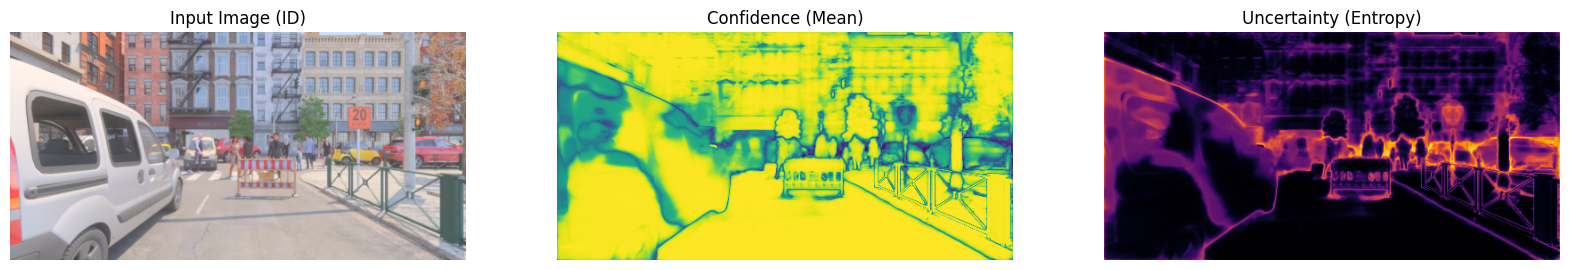


Visualizing Deep Ensembles on OOD data...


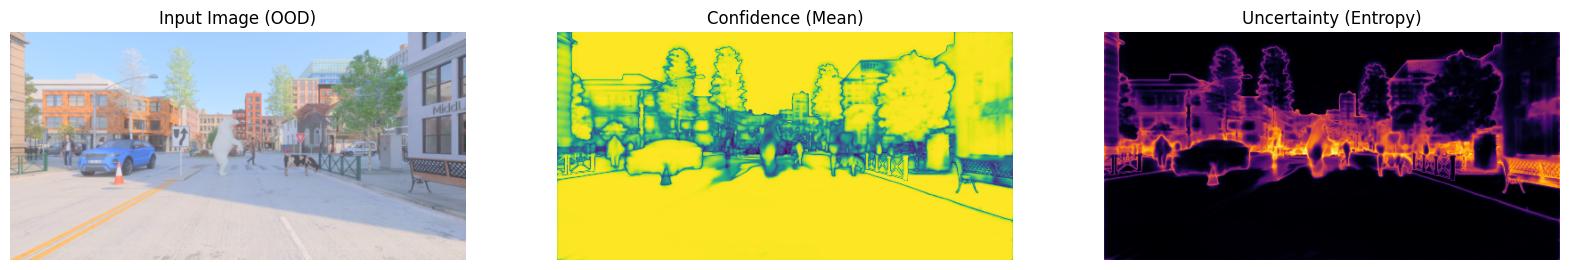


Computing ECE for Deep Ensembles...
Deep Ensembles ECE: 2.15%


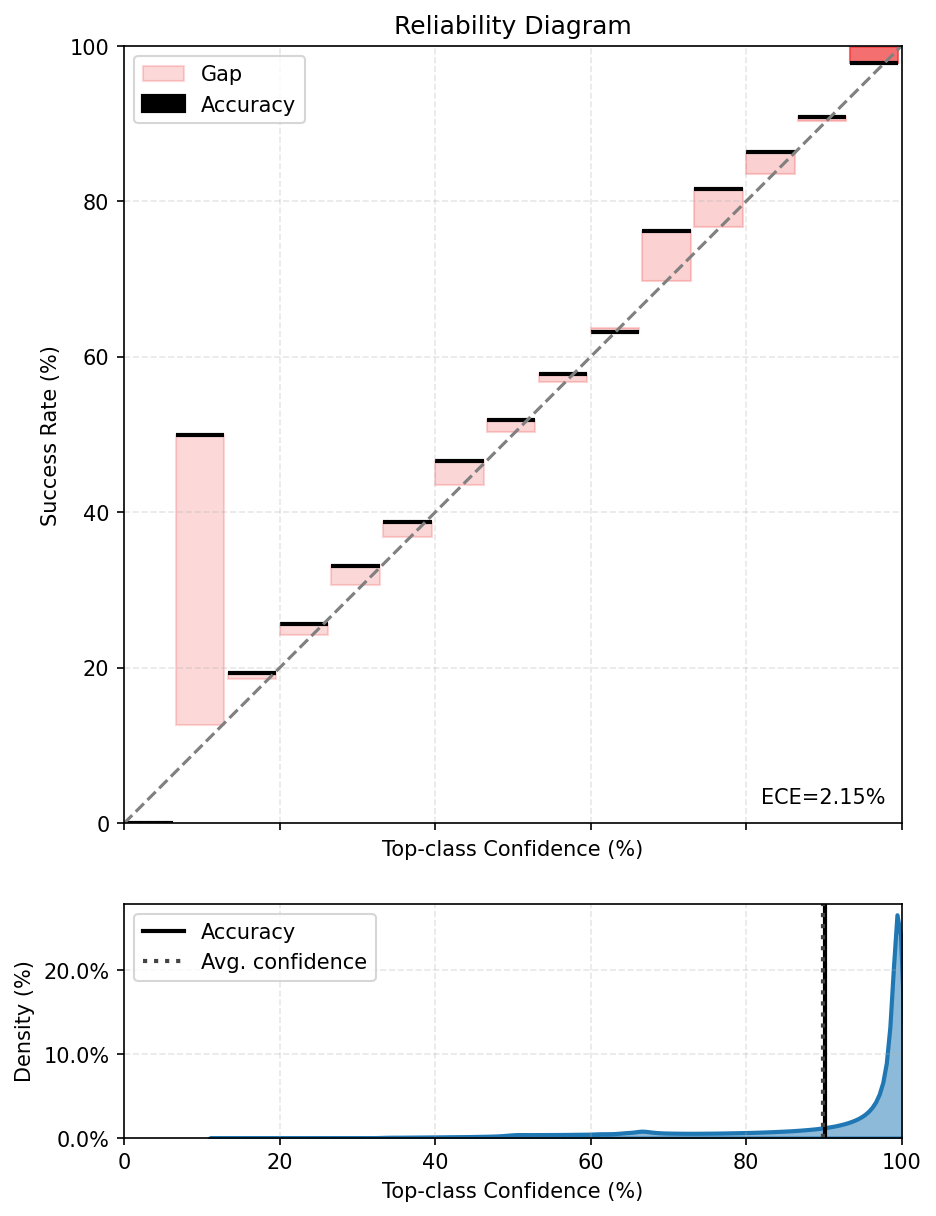

Deep Ensembles evaluation complete.


In [36]:
print("\nVisualizing Deep Ensembles on ID data...")
sample_idx = 0
img_raw,  _ = test_set[sample_idx]
batch_img = img_raw.unsqueeze(0).cuda() # [1, 3, H, W]

ensemble.eval()
with torch.no_grad():
    # Forward pass
    # Deep Ensembles wrapper usually returns [M*B, C, H, W] or [B, M, C, H, W] depending on config.
    # Based on test_ensemble logic, likely [M*B, C, H, W] for B=1
    outputs = ensemble(batch_img)
    
    # Reshape logic mirrors test_ensemble function
    if outputs.shape[0] == num_estimators * 1: # B=1
        outputs = rearrange(outputs, "(m b) c h w -> m b c h w", m=num_estimators, b=1)
    
    # Probabilities
    probs = outputs.softmax(dim=2) # [M, 1, C, H, W]
    
    # Ensemble Mean
    mean_probs = probs.mean(dim=0).squeeze(0) # [C, H, W]
    
    # Confidence and Entropy
    confidence, pred = mean_probs.max(dim=0) # [H, W]
    entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-6), dim=0) # [H, W]

# Visualization Prep
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_raw.device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_raw.device)
img_show = img_raw * std + mean
img_show = torch.clamp(img_show, 0, 1)
img_pil = F.to_pil_image(img_show)

confidence_img = F.to_pil_image(confidence.cpu())

entropy_vis = entropy.cpu()
# Normalize entropy for better visualization [0, 1]
entropy_vis = (entropy_vis - entropy_vis.min()) / (entropy_vis.max() - entropy_vis.min())
entropy_vis_img = F.to_pil_image(entropy_vis)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(img_pil)
ax1.set_title("Input Image (ID)")
ax1.axis('off')

ax2.imshow(confidence_img)
ax2.set_title("Confidence (Mean)")
ax2.axis('off')

ax3.imshow(entropy_vis_img, cmap='inferno')
ax3.set_title("Uncertainty (Entropy)")
ax3.axis('off')
plt.show()


print("\nVisualizing Deep Ensembles on OOD data...")
sample_idx = 0
img_ood, _ = test_ood_set[sample_idx]
batch_img_ood = img_ood.unsqueeze(0).cuda()

ensemble.eval()
with torch.no_grad():
    outputs = ensemble(batch_img_ood)
    if outputs.shape[0] == num_estimators * 1:
        outputs = rearrange(outputs, "(m b) c h w -> m b c h w", m=num_estimators, b=1)
    
    probs = outputs.softmax(dim=2)
    mean_probs = probs.mean(dim=0).squeeze(0)
    
    confidence_ood, _ = mean_probs.max(dim=0)
    entropy_ood = -torch.sum(mean_probs * torch.log(mean_probs + 1e-6), dim=0)

img_show_ood = img_ood.cpu() * std + mean
img_show_ood = torch.clamp(img_show_ood, 0, 1)
img_pil_ood = F.to_pil_image(img_show_ood)
entropy_vis_ood = entropy_ood.cpu()
entropy_vis_ood = (entropy_vis_ood - entropy_vis_ood.min()) / (entropy_vis_ood.max() - entropy_vis_ood.min())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(img_pil_ood)
ax1.set_title("Input Image (OOD)")
ax1.axis('off')

ax2.imshow(F.to_pil_image(confidence_ood.cpu()))
ax2.set_title("Confidence (Mean)")
ax2.axis('off')

ax3.imshow(F.to_pil_image(entropy_vis_ood), cmap='inferno')
ax3.set_title("Uncertainty (Entropy)")
ax3.axis('off')
plt.show()


# ECE
from torch_uncertainty.metrics import CalibrationError

print("\nComputing ECE for Deep Ensembles...")
ece_metric_ens = CalibrationError(task='multiclass', num_classes=num_classes, num_bins=15, norm="l1").cuda()

ensemble.eval()
with torch.no_grad():
    for batch_data in test_loader:
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        labels[labels >= 19] = 255
        if labels.ndim == 4: 
            labels = labels.squeeze(1) # [B, H, W] or [B, 1, H, W]

        B = img.shape[0]
        outputs = ensemble(img)
        
        # Reshape to [M, B, C, H, W] for averaging
        if outputs.shape[0] == B * num_estimators: 
             outputs = rearrange(outputs, "(m b) c h w -> m b c h w", m=num_estimators, b=B)
        
        # Mean Probs (Ensemble averaging)
        mean_probs = outputs.softmax(dim=2).mean(dim=0) # [B, C, H, W]
        
        # Flatten for Metric
        flatten_probs = rearrange(mean_probs, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255
        
        ece_metric_ens.update(flatten_probs[valid_mask], flatten_labels[valid_mask])

print(f"Deep Ensembles ECE: {ece_metric_ens.compute()*100.0:.2f}%")
fig, ax = ece_metric_ens.plot()
plt.show()

print("Deep Ensembles evaluation complete.")

## F. Uncertainty evaluations with Packed-Ensembles
**Q\15 Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty**



Training Packed-Ensembles UNet...
Loading pre-trained Packed UNet...

Evaluating Packed-Ensembles Uncertainty...
Visualizing Packed-Ensembles on ID data:


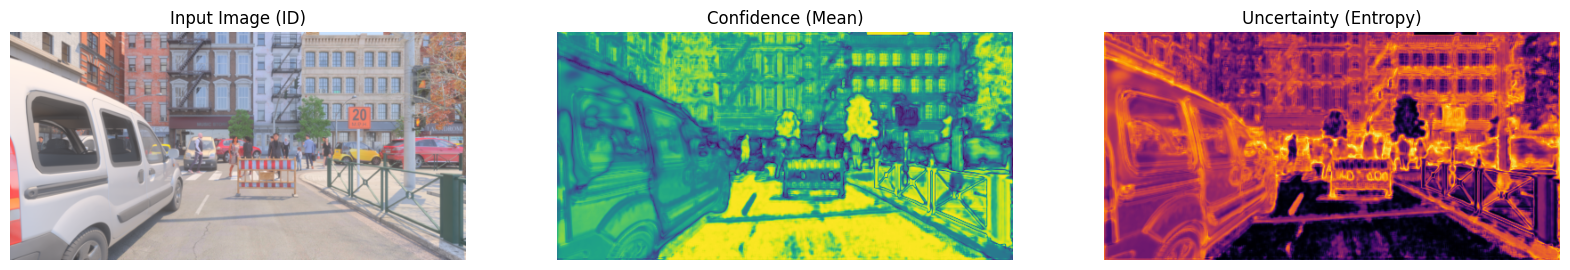


Visualizing Packed-Ensembles on OOD data...


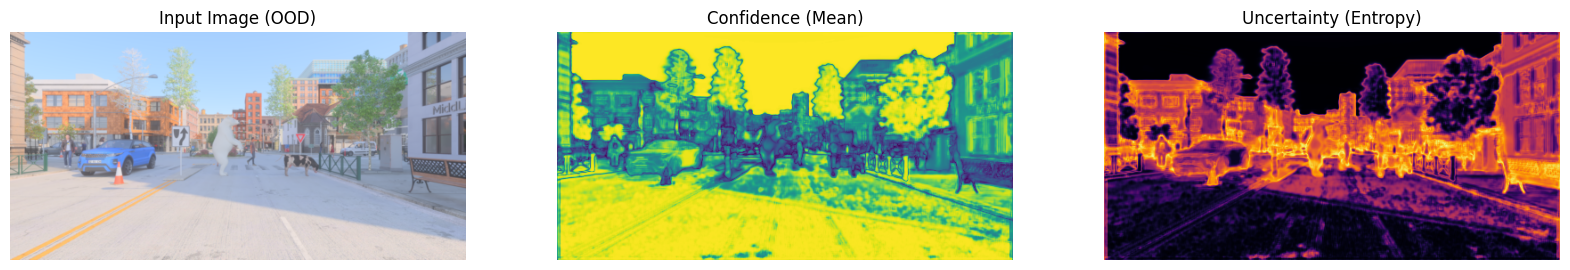


Computing ECE for Packed-Ensembles...
Packed-Ensembles ECE: 16.92%


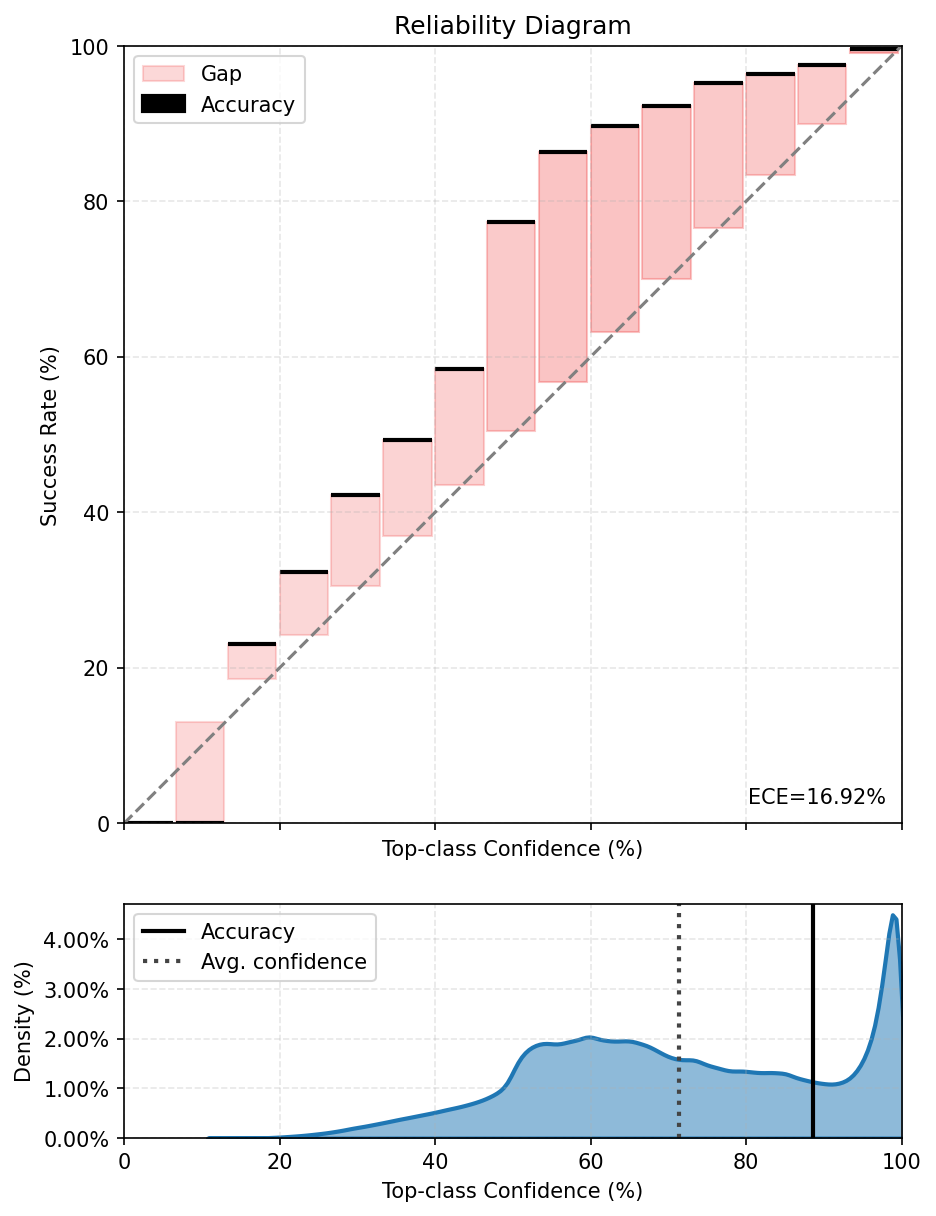

Packed-Ensembles evaluation complete.


In [37]:
from torch_uncertainty.layers import PackedConv2d
import torch.nn.functional as F_nn
import gc
packed_alpha = 2 # Since our GPU (20 GB memory, provided by computers at X) is limited, we have to use a smaller alpha.
packed_epochs = nb_epochs

# Reset hyperparameters for Packed-Ensembles UNet
batch_size = 32
learning_rate = 1e-1
# weight_decay=5e-4
# lr_decay_epochs=40
# lr_decay=0.1
# nb_epochs=100


# # Clearup GPU Memory before training Packed-Ensembles UNet
# try:
#     del model
#     del ensemble
#     del models_list
#     del optimizer
#     del scheduler
# except NameError:
#     pass

torch.cuda.empty_cache()
gc.collect()

print("\nTraining Packed-Ensembles UNet...")

class PackedDoubleConv(nn.Module):
    """(PackedConv2d => BN => ReLU) * 2"""
    def __init__(self, in_ch, out_ch, alpha, num_estimators, gamma=1):
        super().__init__()
        self.conv = nn.Sequential(
            PackedConv2d(
                in_ch,  # 3
                out_ch, # 32
                kernel_size=3, padding=1, alpha=alpha, num_estimators=num_estimators, gamma=gamma
            ),
            nn.BatchNorm2d(out_ch * alpha), # BN on the packed channels
            nn.ReLU(inplace=True),
            
            PackedConv2d(
                out_ch, 
                out_ch, 
                kernel_size=3, padding=1, alpha=alpha, num_estimators=num_estimators, gamma=gamma
            ),
            nn.BatchNorm2d(out_ch * alpha),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class PackedUNet(nn.Module):
    def __init__(self, classes, num_estimators, alpha=2):
        super().__init__()
        self.num_estimators = num_estimators
        self.alpha = alpha
        
        # Encoder
        self.inc = PackedDoubleConv(3, 32, alpha, num_estimators)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), PackedDoubleConv(32, 64, alpha, num_estimators))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), PackedDoubleConv(64, 128, alpha, num_estimators))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), PackedDoubleConv(128, 256, alpha, num_estimators))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), PackedDoubleConv(256, 256, alpha, num_estimators))
        
        # Decoder
        # Up1: Skip connection (x4) has 256 base channels. x (upsampled from x5) has 256 base channels.
        self.up1_conv = PackedDoubleConv(512, 128, alpha, num_estimators)
        
        # Up2: 128 + 128 = 256 in
        self.up2_conv = PackedDoubleConv(256, 64, alpha, num_estimators)
        
        # Up3: 64 + 64 = 128 in
        self.up3_conv = PackedDoubleConv(128, 32, alpha, num_estimators)
        
        # Up4: 32 + 32 = 64 in
        self.up4_conv = PackedDoubleConv(64, 32, alpha, num_estimators)
        
        # Output layer
        self.outc = PackedConv2d(32, classes, kernel_size=1, alpha=alpha, num_estimators=num_estimators)

    def forward(self, x):
        # Packing Input: [B, C, H, W] -> [B, C*alpha, H, W]
        input_packed = x.repeat(1, self.alpha, 1, 1)
        
        x1 = self.inc(input_packed)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Up1
        x = F_nn.interpolate(x5, scale_factor=2, mode='bilinear', align_corners=True)
        if x.shape != x4.shape:
            x = v2.functional.resize(x, size=x4.shape[-2:])     
        x = torch.cat([x4, x], dim=1) 
        x = self.up1_conv(x)

        # Up2
        x = F_nn.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        if x.shape != x3.shape:
             x = v2.functional.resize(x, size=x3.shape[-2:])
        x = torch.cat([x3, x], dim=1)
        x = self.up2_conv(x)
        
        # Up3
        x = F_nn.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        if x.shape != x2.shape:
             x = v2.functional.resize(x, size=x2.shape[-2:])
        x = torch.cat([x2, x], dim=1)
        x = self.up3_conv(x)
        
        # Up4
        x = F_nn.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        if x.shape != x1.shape:
             x = v2.functional.resize(x, size=x1.shape[-2:])
        x = torch.cat([x1, x], dim=1)
        x = self.up4_conv(x)
        
        logits = self.outc(x)
        
        # Output Reshape: [B, Classes*alpha, H, W] -> [B, alpha, Classes, H, W]
        B, C_total, H, W = logits.shape 
        logits = logits.view(B, self.alpha, -1, H, W)
        # logits = rearrange(logits, "b (m c) h w -> b m c h w", m=self.alpha)
        
        return logits


packed_model = PackedUNet(num_classes, num_estimators=packed_alpha, alpha=packed_alpha).cuda()
optimizer_packed = optim.SGD(packed_model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)

# Packed output [B, M, C, H, W]
def train_packed(model, data_loader, optim, criterion, metric):
    model.train()
    epoch_loss = 0.0
    for batch_data in data_loader:
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        labels[labels >= 19] = 255
        if labels.ndim == 4: labels = labels.squeeze(1)

        # Forward
        outputs = model(img) # [B, M, C, H, W]
        
        B, M, C, H_out, W_out = outputs.shape
        outputs_flat = outputs.view(B * M, C, H_out, W_out)
        labels_rep = labels.unsqueeze(1).repeat(1, M, 1, 1).view(B * M, H_out, W_out)
        
        loss = criterion(outputs_flat, labels_rep)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()

        with torch.no_grad():
            mean_probs = outputs.softmax(dim=2).mean(dim=1) # [B, C, H, W]
            flatten_probs = rearrange(mean_probs, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255
            metric.update(flatten_probs[valid_mask], flatten_labels[valid_mask])
        
    return epoch_loss / len(data_loader), metric.compute()

def test_packed(model, data_loader, criterion, metric):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    with torch.no_grad():
        for batch_data in data_loader:
            img = batch_data[0].cuda()
            labels = batch_data[1].cuda()
            labels[labels >= 19] = 255
            if labels.ndim == 4: labels = labels.squeeze(1)

            outputs = model(img) # [B, M, C, H, W]
            B, M, C, H_out, W_out = outputs.shape

            # Loss
            outputs_flat = outputs.view(B * M, C, H_out, W_out)
            labels_rep = labels.unsqueeze(1).repeat(1, M, 1, 1).view(B * M, H_out, W_out)
            loss = criterion(outputs_flat, labels_rep)
            epoch_loss += loss.item()

            # Metric
            mean_probs = outputs.softmax(dim=2).mean(dim=1) # [B, C, H, W]
            flatten_probs = rearrange(mean_probs, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255
            metric.update(flatten_probs[valid_mask], flatten_labels[valid_mask])

    return epoch_loss / len(data_loader), metric.compute()

if skip_training and os.path.exists("packed_unet.pth"):
    print("Loading pre-trained Packed UNet...")
    packed_model.load_state_dict(torch.load("packed_unet.pth"))
else:
    packed_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_packed, step_size=lr_decay_epochs, gamma=lr_decay)
    
    for epoch in range(packed_epochs):
        train_loss, train_miou = train_packed(packed_model, train_loader, optimizer_packed, criterion, metric_train_obj)
        val_loss, val_miou = test_packed(packed_model, val_loader, criterion, metric_val_obj)
        packed_scheduler.step()
        
        print(f"  Packed Epoch {epoch+1}/{packed_epochs} | Train Loss: {train_loss:.4f} | Train mIoU: {train_miou:.4f} | Val Loss: {val_loss:.4f} | Val mIoU: {val_miou:.4f}")
        
    torch.save(packed_model.state_dict(), "packed_unet.pth")


print("\nEvaluating Packed-Ensembles Uncertainty...")

sample_idx = 0
img_raw,  _ = test_set[sample_idx]
batch_img = img_raw.unsqueeze(0).cuda() # [1, 3, H, W]

packed_model.eval()
with torch.no_grad():
    # Forward: [1, M, C, H, W]
    logits_packed = packed_model(batch_img)
    
    # Prob: [1, M, C, H, W]
    probs_packed = logits_packed.softmax(dim=2)
    
    # Ensemble Prediction
    mean_probs = probs_packed.mean(dim=1) # [1, C, H, W]
    confidence, pred = mean_probs.max(dim=1) # [1, H, W]

    # Entropy = - sum(p * log(p))
    entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-6), dim=1) # [1, H, W]

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_raw.device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_raw.device)
img_show = img_raw * std + mean
img_show = torch.clamp(img_show, 0, 1)
img_pil = F.to_pil_image(img_show)

confidence_img = F.to_pil_image(confidence.squeeze(0).cpu())

entropy_vis = entropy.squeeze(0).cpu()
entropy_vis = (entropy_vis - entropy_vis.min()) / (entropy_vis.max() - entropy_vis.min())
entropy_vis_img = F.to_pil_image(entropy_vis)

print("Visualizing Packed-Ensembles on ID data:")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(img_pil)
ax1.set_title("Input Image (ID)")
ax1.axis('off')

ax2.imshow(confidence_img)
ax2.set_title("Confidence (Mean)")
ax2.axis('off')

ax3.imshow(entropy_vis_img, cmap='inferno')
ax3.set_title("Uncertainty (Entropy)")
ax3.axis('off')
plt.show()

# Evaluation on OOD Data
print("\nVisualizing Packed-Ensembles on OOD data...")
sample_idx = 0
img_ood, _ = test_ood_set[sample_idx]
batch_img_ood = img_ood.unsqueeze(0).cuda()

packed_model.eval()
with torch.no_grad():
    logits_packed = packed_model(batch_img_ood)
    probs_packed = logits_packed.softmax(dim=2)
    mean_probs = probs_packed.mean(dim=1)
    confidence_ood, _ = mean_probs.max(dim=1)
    entropy_ood = -torch.sum(mean_probs * torch.log(mean_probs + 1e-6), dim=1)

img_show_ood = img_ood.cpu() * std + mean
img_show_ood = torch.clamp(img_show_ood, 0, 1)
img_pil_ood = F.to_pil_image(img_show_ood.cpu())

entropy_vis_ood = entropy_ood.squeeze(0).cpu()
entropy_vis_ood = (entropy_vis_ood - entropy_vis_ood.min()) / (entropy_vis_ood.max() - entropy_vis_ood.min())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.imshow(img_pil_ood)
ax1.set_title("Input Image (OOD)")
ax1.axis('off')

ax2.imshow(F.to_pil_image(confidence_ood.squeeze(0).cpu()))
ax2.set_title("Confidence (Mean)")
ax2.axis('off')

ax3.imshow(F.to_pil_image(entropy_vis_ood), cmap='inferno')
ax3.set_title("Uncertainty (Entropy)")
ax3.axis('off')
plt.show()

# ECE
from torch_uncertainty.metrics import CalibrationError

print("\nComputing ECE for Packed-Ensembles...")
ece_metric_packed = CalibrationError(task='multiclass', num_classes=num_classes, num_bins=15, norm="l1").cuda()

packed_model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        labels[labels >= 19] = 255
        if labels.ndim == 4: labels = labels.squeeze(1)

        # Forward
        outputs = packed_model(img) # [B, M, C, H, W]
        
        # Mean Probs (Ensemble averaging)
        mean_probs = outputs.softmax(dim=2).mean(dim=1) # [B, C, H, W]
        
        flatten_probs = rearrange(mean_probs, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255
        
        ece_metric_packed.update(flatten_probs[valid_mask], flatten_labels[valid_mask])

print(f"Packed-Ensembles ECE: {ece_metric_packed.compute()*100.0:.2f}%")
fig, ax = ece_metric_packed.plot()
plt.show()

print("Packed-Ensembles evaluation complete.")


Comment: we don't have enough GPU memory to run the training with alpha > 2. What's more, a better set of hyper-parameters are expected to be found, since currently the train accuracy is low and the model cannot learn in the later stages of training.

**Please conclude your report**